# CROSS DOMAIN TRANSFER NLP ASS 3

In [16]:
# Install required libraries
!pip install transformers datasets torch scikit-learn matplotlib seaborn

In [17]:
# Core imports
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Transformers and datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import load_dataset
import warnings
import transformers
warnings.filterwarnings('ignore')

# Check GPU and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [18]:
# Mount Google Drive to save the model persistently
from google.colab import drive
drive.mount('/content/drive')

# Authenticate with Hugging Face and Weights & Biases
from google.colab import userdata
from huggingface_hub import login
import wandb

# Authenticate with Hugging Face
hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)
print("Logged in to Hugging Face")

# Authenticate with Weights & Biases
wandb_token = userdata.get('WANDB_API_KEY')
wandb.login(key=wandb_token)
print("Logged in to Weights & Biases")

# Configuration flags - WHETHER TO TRAIN OR LOAD A MODEL
# Set TRAIN_NEW_MODEL to True to train a new model, or False to load an existing model
TRAIN_NEW_MODEL = True  # Set to True to train, False to load existing
ENABLE_WANDB_LOGGING = True  # Set to False to disable wandb logging

# Define model save path in Google Drive
model_save_path = '/content/drive/MyDrive/roberta-amazon-finetuned'
print(f"Model will be saved to/loaded from: {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Logged in to Hugging Face


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Logged in to Weights & Biases
Model will be saved to/loaded from: /content/drive/MyDrive/roberta-amazon-finetuned


In [19]:
# Load Amazon Polarity dataset
print("Loading Amazon Polarity dataset...")
amazon_dataset = load_dataset("amazon_polarity", split={"train": "train[:10000]", "test": "test[:2500]"})

# Display dataset info
print(f"Amazon dataset structure: {amazon_dataset}")
print(f"Training samples: {len(amazon_dataset['train'])}")
print(f"Test samples: {len(amazon_dataset['test'])}")

# Check dataset features and labels
print(f"Dataset features: {amazon_dataset['train'].features}")
print(f"Label mapping: 0=negative, 1=positive")

Loading Amazon Polarity dataset...
Amazon dataset structure: DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 2500
    })
})
Training samples: 10000
Test samples: 2500
Dataset features: {'label': ClassLabel(names=['negative', 'positive']), 'title': Value('string'), 'content': Value('string')}
Label mapping: 0=negative, 1=positive


In [20]:
# Display sample examples
print("Sample Amazon reviews:")
for i in range(3):
    sample = amazon_dataset['train'][i]
    label = "Positive" if sample['label'] == 1 else "Negative"
    print(f"\nExample {i+1} ({label}):")
    print(f"Title: {sample['title'][:100]}...")
    print(f"Content: {sample['content'][:150]}...")

Sample Amazon reviews:

Example 1 (Positive):
Title: Stuning even for the non-gamer...
Content: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played t...

Example 2 (Positive):
Title: The best soundtrack ever to anything....
Content: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinin...

Example 3 (Positive):
Title: Amazing!...
Content: This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all the more if you've played th...


In [21]:
# Check label distribution
train_labels = amazon_dataset['train']['label']
test_labels = amazon_dataset['test']['label']

print("Amazon dataset label distribution:")
print(f"Training - Negative: {train_labels.count(0)}, Positive: {train_labels.count(1)}")
print(f"Test - Negative: {test_labels.count(0)}, Positive: {test_labels.count(1)}")

Amazon dataset label distribution:
Training - Negative: 5097, Positive: 4903
Test - Negative: 1191, Positive: 1309


In [22]:
# Fix IMDb dataset to get balanced samples
print("Loading balanced IMDb dataset...")
imdb_full = load_dataset("imdb")

# Get balanced sample from test set
imdb_test = imdb_full['test']
negative_samples = [i for i, label in enumerate(imdb_test['label']) if label == 0][:1250]
positive_samples = [i for i, label in enumerate(imdb_test['label']) if label == 1][:1250]

# Combine and shuffle indices
balanced_indices = negative_samples + positive_samples
np.random.shuffle(balanced_indices)

# Create balanced dataset
imdb_balanced = imdb_test.select(balanced_indices)
print(f"Balanced IMDb samples: {len(imdb_balanced)}")

# Check new distribution
imdb_labels = imdb_balanced['label']
print(f"IMDb - Negative: {imdb_labels.count(0)}, Positive: {imdb_labels.count(1)}")

Loading balanced IMDb dataset...
Balanced IMDb samples: 2500
IMDb - Negative: 1250, Positive: 1250


In [23]:
# Preprocessing function to combine Amazon title and content
def preprocess_amazon_text(example):
    # Combine title and content for Amazon reviews
    example['text'] = f"{example['title']} {example['content']}"
    return example

# Apply preprocessing to Amazon dataset
amazon_processed = amazon_dataset.map(preprocess_amazon_text)

print("Amazon preprocessing complete")
print("Sample processed text:")
print(amazon_processed['train'][0]['text'][:200])

Amazon preprocessing complete
Sample processed text:
Stuning even for the non-gamer This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cros


In [24]:
# Initialize RoBERTa tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'],
                    truncation=True,
                    padding=True,
                    max_length=512)

print("Tokenizer loaded successfully")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

Tokenizer loaded successfully
Tokenizer vocab size: 50265


In [25]:
# Tokenize Amazon dataset
print("Tokenizing Amazon dataset...")
amazon_tokenized = amazon_processed.map(tokenize_function, batched=True)

# Remove original text columns to save memory
amazon_tokenized = amazon_tokenized.remove_columns(['title', 'content', 'text'])

print("Amazon tokenization complete")
print(f"Tokenized features: {amazon_tokenized['train'].features}")

Tokenizing Amazon dataset...


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Amazon tokenization complete
Tokenized features: {'label': ClassLabel(names=['negative', 'positive']), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8'))}


In [26]:
# Tokenize IMDb dataset
print("Tokenizing IMDb dataset...")
imdb_tokenized = imdb_balanced.map(tokenize_function, batched=True)

# Remove original text column
imdb_tokenized = imdb_tokenized.remove_columns(['text'])

print("IMDb tokenization complete")
print(f"Tokenized features: {imdb_tokenized.features}")

Tokenizing IMDb dataset...
IMDb tokenization complete
Tokenized features: {'label': ClassLabel(names=['neg', 'pos']), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8'))}


In [27]:
# Set format for PyTorch
amazon_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
imdb_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Check tokenized sample
print("Sample tokenized data:")
sample = amazon_tokenized['train'][0]
print(f"Input IDs shape: {sample['input_ids'].shape}")
print(f"Attention mask shape: {sample['attention_mask'].shape}")
print(f"Label: {sample['label']}")

# Split Amazon dataset for training/validation
train_size = int(0.85 * len(amazon_tokenized['train']))
val_size = len(amazon_tokenized['train']) - train_size

amazon_train = amazon_tokenized['train'].select(range(train_size))
amazon_val = amazon_tokenized['train'].select(range(train_size, train_size + val_size))

print(f"Training samples: {len(amazon_train)}")
print(f"Validation samples: {len(amazon_val)}")
print(f"Amazon test samples: {len(amazon_tokenized['test'])}")
print(f"IMDb test samples: {len(imdb_tokenized)}")

Sample tokenized data:
Input IDs shape: torch.Size([327])
Attention mask shape: torch.Size([327])
Label: 1
Training samples: 8500
Validation samples: 1500
Amazon test samples: 2500
IMDb test samples: 2500


In [28]:
print(f"Transformers version: {transformers.__version__}")

# Define training arguments (properly fixed version)
training_args = TrainingArguments(
    output_dir='./roberta-amazon-finetuned',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="steps",  # Set evaluation strategy to match save strategy
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,  # Match eval_steps for consistency
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="wandb" if ENABLE_WANDB_LOGGING else None,
    seed=42,
)

print("Training arguments configured successfully")
print(f"Evaluation strategy: {training_args.eval_strategy}")
print(f"Save strategy: {training_args.save_strategy}")
print(f"WandB logging: {'Enabled' if ENABLE_WANDB_LOGGING else 'Disabled'}")

Transformers version: 4.55.0
Training arguments configured successfully
Evaluation strategy: IntervalStrategy.STEPS
Save strategy: SaveStrategy.STEPS
WandB logging: Enabled


In [29]:
# Define a function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1}

# CONDITIONAL TRAINER CREATION
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

if TRAIN_NEW_MODEL:
    print("=== TRAINING MODE ===")
    # Initialize the model for training
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=amazon_train,
        eval_dataset=amazon_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    print("Trainer created for training")
    print(f"Training dataset size: {len(trainer.train_dataset)}")
    print(f"Evaluation dataset size: {len(trainer.eval_dataset)}")

    # Training and saving
    print("Starting training...")
    print("This will take several minutes depending on your GPU...")
    trainer.train()
    print("Training completed!")

    trainer.save_model(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Model and tokenizer saved to '{model_save_path}'")
    print("Model will persist after runtime restarts!")

else:
    print("=== LOADING MODE ===")
    print(f"Loading saved model from: {model_save_path}")
    saved_model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
    saved_model.to(device)
    trainer = Trainer(
        model=saved_model,
        args=training_args,
        train_dataset=amazon_train,
        eval_dataset=amazon_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    print("Trainer created with loaded model")
    print(f"Model loaded on {device}")

=== TRAINING MODE ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer created for training
Training dataset size: 8500
Evaluation dataset size: 1500
Starting training...
This will take several minutes depending on your GPU...


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.296400,0.268997,0.915333,0.915330


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.296400,0.268997,0.915333,0.915330
1000,0.183400,0.217174,0.935333,0.935185
1500,0.087300,0.237997,0.947333,0.947342


Training completed!
Model and tokenizer saved to '/content/drive/MyDrive/roberta-amazon-finetuned'
Model will persist after runtime restarts!


In [38]:
# Load model for evaluation based on training mode
if TRAIN_NEW_MODEL:
    # Use the model from training
    best_model = trainer.model
    print("Using freshly trained model for evaluation")
else:
    # Load the saved model for evaluation
    print(f"Loading saved model for evaluation from: {model_save_path}")
    best_model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
    print("Saved model loaded for evaluation")

best_model.to(device)
best_model.eval()
print(f"Model ready for evaluation on {device}")

Using freshly trained model for evaluation
Model ready for evaluation on cuda


In [39]:
# Define compute_metrics function for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')
    return {
        'accuracy': accuracy,
        'f1': f1
    }

# Define the evaluation function
def evaluate_model(model, dataset, dataset_name):
    print(f"\nEvaluating on {dataset_name}...")
    trainer = Trainer(
        model=model,
        args=TrainingArguments(output_dir='./temp_eval', report_to="none"),
        eval_dataset=dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
    )
    metrics = trainer.evaluate()
    accuracy = metrics["eval_accuracy"]
    f1 = metrics["eval_f1"]

    # Get predictions and true labels for confusion matrix
    predictions = trainer.predict(dataset).predictions
    preds = np.argmax(predictions, axis=-1)
    true_labels = np.array(dataset['label'])

    print(f"{dataset_name} Accuracy: {accuracy:.4f}")
    print(f"{dataset_name} F1 Score: {f1:.4f}")

    return accuracy, f1, preds, true_labels

In [36]:
print("Initializing RoBERTa model for sequence classification...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},
    label2id={"NEGATIVE": 0, "POSITIVE": 1}
)
model.to(device)
print(f"Model loaded and moved to {device}")

Initializing RoBERTa model for sequence classification...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to cuda


In [37]:
# Now run the Amazon evaluation
print("=" * 60)
print("3.1: SAME-DOMAIN EVALUATION (Amazon → Amazon)")
print("=" * 60)

amazon_accuracy, amazon_f1, amazon_preds, amazon_true = evaluate_model(
    best_model, amazon_tokenized['test'], "Amazon Test Set"
)

3.1: SAME-DOMAIN EVALUATION (Amazon → Amazon)

Evaluating on Amazon Test Set...


Amazon Test Set Accuracy: 0.9364
Amazon Test Set F1 Score: 0.9407


In [40]:
# Import numpy
import numpy as np

# Reload IMDb dataset for cross-domain evaluation
print("Reloading IMDb dataset...")
imdb_full = load_dataset("imdb")
imdb_test = imdb_full['test']

# Get balanced sample (1250 each class)
negative_samples = [i for i, label in enumerate(imdb_test['label']) if label == 0][:1250]
positive_samples = [i for i, label in enumerate(imdb_test['label']) if label == 1][:1250]
balanced_indices = negative_samples + positive_samples
np.random.shuffle(balanced_indices)

imdb_balanced = imdb_test.select(balanced_indices)
print(f"IMDb balanced samples: {len(imdb_balanced)}")

Reloading IMDb dataset...
IMDb balanced samples: 2500


In [41]:
# 3.2: Cross-domain evaluation on IMDb
print("\n" + "=" * 60)
print("3.2: CROSS-DOMAIN TRANSFER (Amazon → IMDb)")
print("=" * 60)

imdb_accuracy, imdb_f1, imdb_preds, imdb_true = evaluate_model(
    best_model, imdb_tokenized, "IMDb Test Set"
)


3.2: CROSS-DOMAIN TRANSFER (Amazon → IMDb)

Evaluating on IMDb Test Set...


IMDb Test Set Accuracy: 0.9160
IMDb Test Set F1 Score: 0.9202


In [42]:
# 3.3: Performance comparison and analysis
print("\n" + "=" * 50)
print("TRANSFER LEARNING PERFORMANCE ANALYSIS")
print("=" * 50)

print("PERFORMANCE SUMMARY:")
print(f"Amazon (Same Domain)    - Accuracy: {amazon_accuracy:.4f} ({amazon_accuracy*100:.2f}%)")
print(f"IMDb (Cross Domain)     - Accuracy: {imdb_accuracy:.4f} ({imdb_accuracy*100:.2f}%)")
print(f"Amazon F1 Score:        {amazon_f1:.4f}")
print(f"IMDb F1 Score:          {imdb_f1:.4f}")

# Performance drop analysis
accuracy_drop = amazon_accuracy - imdb_accuracy
performance_retention = (imdb_accuracy / amazon_accuracy) * 100

print(f"\nTRANSFER ANALYSIS:")
print(f"Performance Drop:       {accuracy_drop:.4f} ({accuracy_drop*100:.2f} percentage points)")
print(f"Performance Retention:  {performance_retention:.2f}%")

if accuracy_drop < 0.05:
    transfer_quality = "Excellent"
elif accuracy_drop < 0.10:
    transfer_quality = "Good"
elif accuracy_drop < 0.15:
    transfer_quality = "Fair"
else:
    transfer_quality = "Poor"

print(f"Transfer Quality:       {transfer_quality}")


TRANSFER LEARNING PERFORMANCE ANALYSIS
PERFORMANCE SUMMARY:
Amazon (Same Domain)    - Accuracy: 0.9364 (93.64%)
IMDb (Cross Domain)     - Accuracy: 0.9160 (91.60%)
Amazon F1 Score:        0.9407
IMDb F1 Score:          0.9202

TRANSFER ANALYSIS:
Performance Drop:       0.0204 (2.04 percentage points)
Performance Retention:  97.82%
Transfer Quality:       Excellent


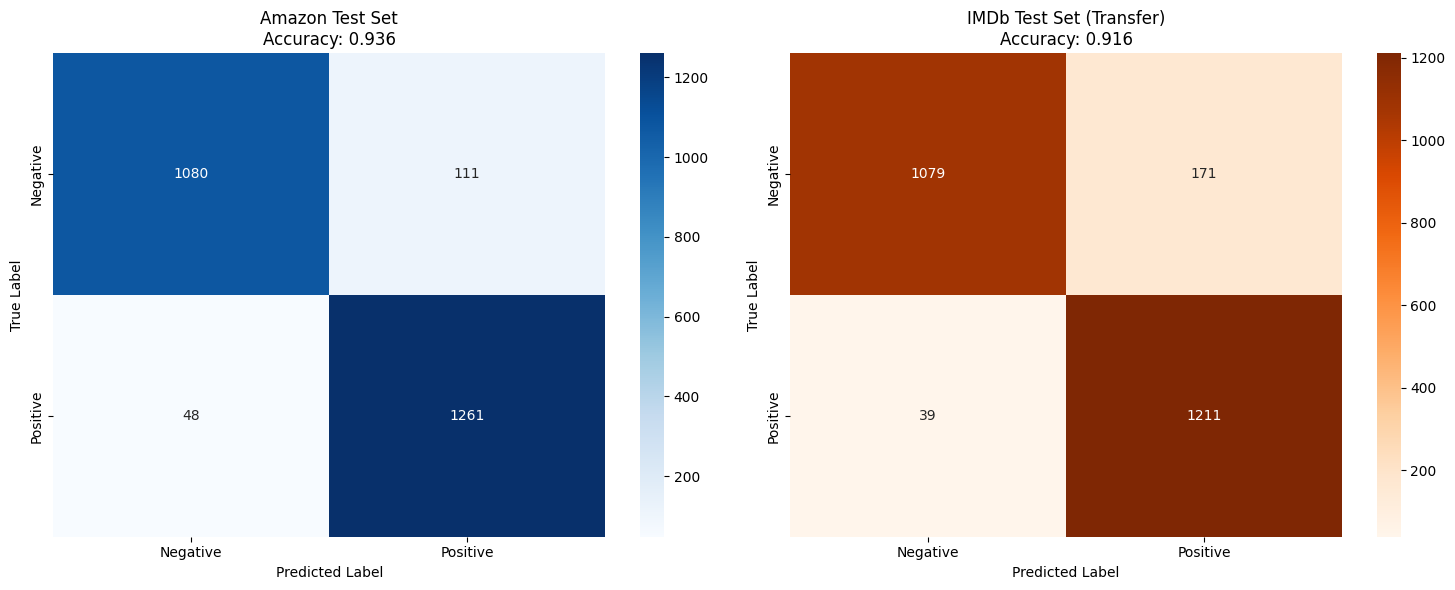

Confusion matrices generated


In [43]:
# 3.4: Create confusion matrices for both domains
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Amazon confusion matrix
cm_amazon = confusion_matrix(amazon_true, amazon_preds)
sns.heatmap(cm_amazon, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=axes[0])
axes[0].set_title(f'Amazon Test Set\nAccuracy: {amazon_accuracy:.3f}')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# IMDb confusion matrix
cm_imdb = confusion_matrix(imdb_true, imdb_preds)
sns.heatmap(cm_imdb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=axes[1])
axes[1].set_title(f'IMDb Test Set (Transfer)\nAccuracy: {imdb_accuracy:.3f}')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

print("Confusion matrices generated")

In [44]:
# 3.5: Domain transfer insights
print("\n" + "=" * 60)
print("3.5: DOMAIN TRANSFER INSIGHTS")
print("=" * 60)

print(" ANALYSIS:")
print("1. SOURCE DOMAIN: Amazon product reviews (mixed categories)")
print("2. TARGET DOMAIN: IMDb movie reviews")
print("3. TRANSFER TYPE: Cross-domain sentiment classification")

print(f"\n KEY FINDINGS:")
print(f"• Same-domain accuracy: {amazon_accuracy*100:.2f}% (Amazon → Amazon)")
print(f"• Cross-domain accuracy: {imdb_accuracy*100:.2f}% (Amazon → IMDb)")
print(f"• Performance retention: {performance_retention:.1f}%")

# Calculate baseline comparison (random would be 50%)
baseline_improvement_amazon = (amazon_accuracy - 0.5) * 100
baseline_improvement_imdb = (imdb_accuracy - 0.5) * 100

print(f"\n BASELINE COMPARISONS:")
print(f"• Amazon improvement over random: +{baseline_improvement_amazon:.1f} percentage points")
print(f"• IMDb improvement over random: +{baseline_improvement_imdb:.1f} percentage points")

if imdb_accuracy > 0.8:
    conclusion = "The model shows strong cross-domain transfer capabilities!"
elif imdb_accuracy > 0.7:
    conclusion = "The model demonstrates good cross-domain generalization."
elif imdb_accuracy > 0.6:
    conclusion = "The model shows moderate transfer learning success."
else:
    conclusion = "The model struggles with cross-domain transfer."

print(f"\n CONCLUSION: {conclusion}")


3.5: DOMAIN TRANSFER INSIGHTS
 ANALYSIS:
1. SOURCE DOMAIN: Amazon product reviews (mixed categories)
2. TARGET DOMAIN: IMDb movie reviews
3. TRANSFER TYPE: Cross-domain sentiment classification

 KEY FINDINGS:
• Same-domain accuracy: 93.64% (Amazon → Amazon)
• Cross-domain accuracy: 91.60% (Amazon → IMDb)
• Performance retention: 97.8%

 BASELINE COMPARISONS:
• Amazon improvement over random: +43.6 percentage points
• IMDb improvement over random: +41.6 percentage points

 CONCLUSION: The model shows strong cross-domain transfer capabilities!
